In [5]:
!python -V

Python 3.9.18


In [6]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import pyarrow.parquet as pq
import requests

In [7]:
def read_dataframe(url):
    # url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-10.parquet"
    response = requests.get(url)
    file_path = url.split("/")[-1]
    # "green_tripdata_2023-10.parquet"

    with open(file_path, "wb") as file:
        file.write(response.content)
    df = pd.read_parquet(file_path)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [8]:
df_train = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-10.parquet")
df_val = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-11.parquet")

In [9]:
# df_train['categorical'] = df_train[['PULocationID', 'DOLocationID']]
# df_val['PU_DO'] = df_val[['PULocationID', 'DOLocationID']]
# df[categorical] = df[categorical].astype('str')

In [10]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df_train[categorical] = df_train[categorical].astype('str')
df_val[categorical] = df_val[categorical].astype('str')

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values


In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.985611973845232

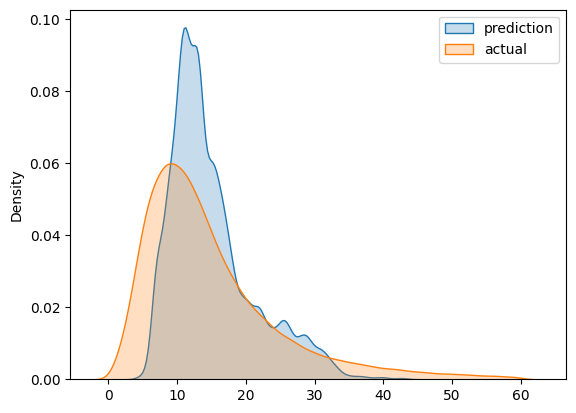

In [13]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)

plt.legend()
plt.show()

In [14]:
with open('model/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [15]:
rg = Ridge()
rg.fit(X_train, y_train)

y_pred = rg.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.983225977862511

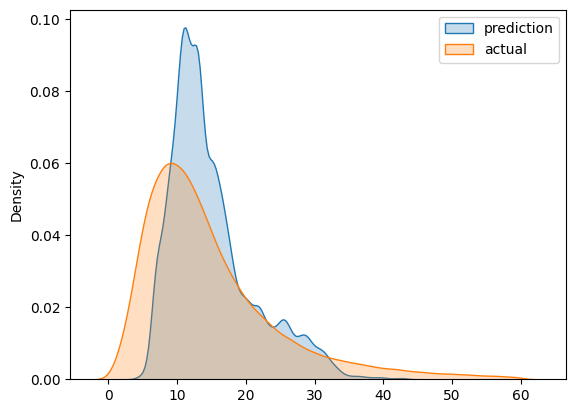

In [16]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)

plt.legend()
plt.show()

In [17]:
with open('model/ridge.bin', 'wb') as f_out:
    pickle.dump((dv, rg), f_out)

In [18]:
ls = Lasso(0.01)
ls.fit(X_train, y_train)

y_pred = ls.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


8.242895715123245

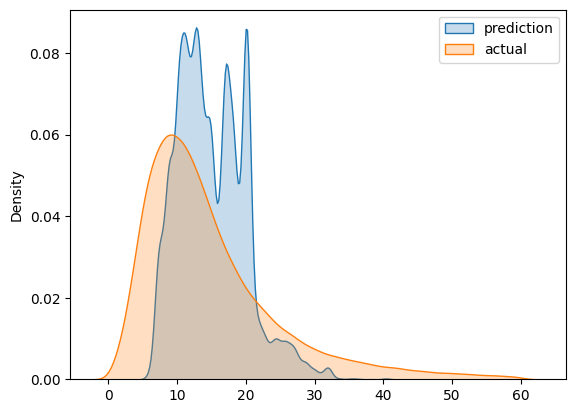

In [19]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)

plt.legend()
plt.show()

In [20]:
with open('model/lasso.bin', 'wb') as f_out:
    pickle.dump((dv, ls), f_out)